## Classification of the CIFAR-10 Dataset

This is a reflective report on the universal deep learning workflow and how it is applied it in the image classification of the CIFAR-10 Dataset.

---

1. Defining the problem and Assembling a Dataset
    - The Problem
    - The Data
    - Naive Baseline
2. Choosing a Measure of Success
    - Primary Metrics
    - Additional Metrics
3. Deciding on an Evaluation Protocol
4. Preparing the Data
    - Preprocessing
    - Post-Processing & Verification
5. Developing and Comparing Two Small Models
    - Model 1 (two hidden 16-unit layers)
    - Model 2 (one hidden 32-unit layer)
    - Comparison & Discussion
6. Scaling up: Overfitting Experiment
    - Model 3 (four dense 128-unit layers)
    - Results & Discussion
7. Regularizing and Hyperparameter Tuning
    - Experiments Setup
    - Experiments results & Discussion
8. Final Model and Test Evaluation
    - Model 4 (Best Hyper-parameters)
    - Results & Discussion

In [34]:
a = 1+1
# the notebook often deadhangs on loading
# libraries as a first cell call
# some simple python code seems to stop
# the kernel from deadhanging

# test tf gpu access
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1 | Defining the problem and Assembling a Dataset
---
##### The Problem
The CIFAR-10 Consists of 60,000 32x32 color images labeled into 10 classes, with 50,000 for training and 10,000 for testing. Classes include: airplane, car, bird, cat, deer, dog, frog, horse, ship, truck.

Models trained on the CIFAR-10 dataset and other similar datasets have real world applications in object recognization for autonomous systems such as robotics and autonomous driving. The models used in object recognition are critical to the functionality of these systems as a miss-classified or un-recognized object can cause the system to make decisions on false information potentially leading to human harm in both robotics and autonomous driving.

The CIFAR-10 dataset represents a multi-class single label problem, where the objective of the model is to learn intermediate representations of the data that facilitate a single label being assigned per input sample.

##### The Data
The 60,000 samples in the CIFAR-10 dataset are split into 10 classes, encoded as an integer 0-9. We can check the balance of these classes by visualizing the distribution of the number of samples assigned to each class.

In [35]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# load cifar-10 dataset (if not already loaded)
if 'cifar10_data' not in globals():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# using a tf.data pipeline for gpu optimization
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (
    train_ds
    .shuffle(buffer_size=10000)
    .batch(256, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# ensure that when we compile models
# set run_eagerly to False for performance
# e.g. model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'],
#                   run_eagerly=False)

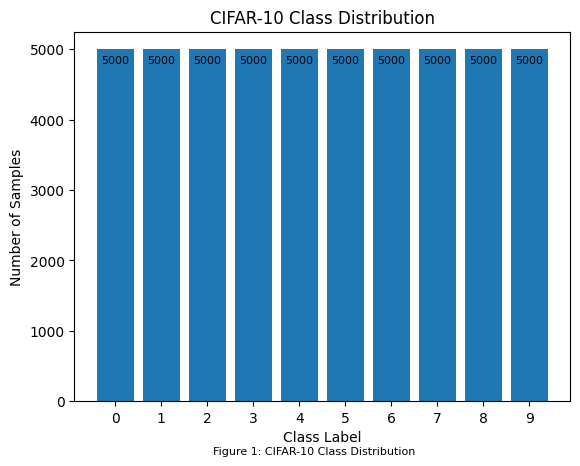

In [36]:
# plot class distribution
classes, counts = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots()
ax.bar(classes, counts)
ax.set_xticks(classes)
ax.set_xticklabels(classes)
ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Samples')
ax.set_title('CIFAR-10 Class Distribution')
# figure text
fig.text(0.5,
         0,
         'Figure 1: CIFAR-10 Class Distribution',
         ha='center',
         fontsize=8)
# add counts on top of bars
for i, count in zip(classes, counts):
    ax.text(i,
            count -200,
            str(count),
            ha='center',
            fontsize=8)
plt.show()

CIFAR-10 contains 10 classes with exactly 5,000 images per class in the standard training set, implying a perfectly balanced class distribution. Class imbalance is a common source of bias in supervised learning: when some classes are over-represented, a neural network may learn internal representations that disproportionately favour those classes, while under-represented classes may contribute insufficient gradient signal for robust feature learning. Where imbalance exists, standard remedies include oversampling minority classes, undersampling majority classes, or applying class-weighted losses so that errors on minority classes are penalized more heavily during gradient-based optimization.

Each CIFAR-10 sample is a 32×32 RGB image, which may be viewed as a 32×32×3 tensor. Although the raw data are stored as 8-bit integers with values in the range 0–255, neural networks typically operate more effectively on continuous inputs; therefore, pixel intensities are commonly rescaled to the range 0–1 (or alternatively standardized). The bounded nature of image data makes this normalization straightforward and helps avoid poorly conditioned optimization. In particular, if features are on substantially different scales, early training can become unstable because parameter updates may be dominated by gradients associated with high-magnitude features, slowing convergence or producing erratic learning dynamics.

A further characteristic of image data is the strong local correlation between neighbouring pixels. However, fully connected networks require images to be flattened into a one-dimensional vector, which removes explicit spatial structure and encourages the model to treat the input as an unstructured set of features. This preprocessing choice discards inductive biases that could otherwise be exploited. Nevertheless, high accuracy can still be achieved with multilayer perceptrons on some vision tasks (e.g., MNIST), indicating that spatial structure, while informative, is not always essential for reasonable performance at small image resolutions.

For experimentation, the dataset will be partitioned into 40,000 training samples, 10,000 validation samples, and 10,000 test samples. Models will be trained on the training set, while hyperparameters are selected using validation performance. The final configuration will then be retrained using the combined training and validation data before evaluation on the held-out test set. This protocol reduces the risk of test-set leakage and provides an unbiased estimate of generalization to previously unseen data.

##### Naive Baseline

To contextualize performance, a baseline model will be used. A suitable baseline is a single-layer softmax classifier (Dense(10)), equivalent to multinomial logistic regression on flattened pixel features. This model should exceed random guessing while remaining sufficiently simple that subsequent improvements can be attributed to increased representational capacity rather than evaluation artefacts.

In [37]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.utils import to_categorical

# one-hot encode labels
y_train_oh = to_categorical(y_train, num_classes=10)
y_test_oh = to_categorical(y_test, num_classes=10)

# build simple feedforward neural network
model = Sequential()
model.add(Input(shape = (32, 32, 3))) # CIFAR-10 image shape
model.add(Flatten()) # flatten 2D images to 1D vectors
model.add(Dense(10, activation='softmax')) # output layer for 10 classes

# compile model
model.compile(optimizer='SGD',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        30,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# seed
tf.random.set_seed(128)

# train model
model.fit(X_train,
          y_train_oh,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, y_test_oh))

# evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10


/home/administrator/wsl-tf/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:1172: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2139 - loss: 84420.8984 - val_accuracy: 0.2078 - val_loss: 82711.0938
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2417 - loss: 72997.9609 - val_accuracy: 0.1787 - val_loss: 89154.2812
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2481 - loss: 70396.7109 - val_accuracy: 0.1879 - val_loss: 84621.0078
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2561 - loss: 68030.0859 - val_accuracy: 0.2616 - val_loss: 60875.1367
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2597 - loss: 66777.5391 - val_accuracy: 0.1838 - val_loss: 129054.6406
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2601 - loss: 67261.1797 - val_accuracy: 0.1817 - val_loss: 116276.7109
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2610 - loss: 66559.2734 - val_accuracy: 0.2226 - val_loss: 93690.0781
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6

The baseline model achieves an accuracy of 21.6%. This is better than random guessing, which would achieve around 10% accuracy, and will serve well as a gague for the success of the more advanced models.

### 2 | Choosing a Measure of Success
---



##### Primary Metrics
Accuracy is the standard and accepted primary measure of success on a balanced dataset. Accuracy is the proportion of correct predictions as a percentage of total predictions, and it is appropriate for multiclass classification problems.

If a dataset is imbalanced, for example with a 75%/25% split across two classes, then a model that predicts class 0 all the time achieves a deceptive 75% accuracy, when in reality it may have learnt very little from the data. Since CIFAR-10 is balanced, this issue cannot arise; if imbalance were present, alternative metrics (e.g., class-wise precision/recall or weighted scores) would be more informative.

##### Additional Metrics

Additional metrics for evaluation and diagnostics include a confusion matrix. A confusion matrix is an (n \times n) matrix in which each entry represents a prediction outcome: entries correspond to combinations of true labels and predicted labels. Elements on the diagonal represent correct classifications, whereas off-diagonal elements represent errors. This enables identification of systematic mistakes and pairs of classes that are frequently confused.

A second additional metric is top-2 accuracy. Top-2 accuracy is similar to accuracy, but counts a prediction as correct when the true label lies within the two most confident predicted classes for that sample. This is useful for assessing near-misses where the model’s second choice is often correct.

### 3 | Deciding on an Evaluation Protocol
---
For this dataset, a three-way split will be used: 40,000 training samples, 10,000 validation samples, and 10,000 test samples. This provides sufficient training data to generalize while retaining a substantial validation set for hyperparameter tuning.

Validation prevents overfitting by approximating the test set, enabling iterative model refinement without directly evaluating on the final test set. This keeps results unbiased, with no test data (or information derived from the test data) contaminating the training process.

Cross-validation is the process of splitting the training data into (K) folds. The model is trained on (K-1) folds and the remaining (K)th fold is used for validation. This is repeated so that each fold serves as the validation set once, and validation metrics are averaged across folds to obtain more robust estimates that are less sensitive to small-sample effects. Cross-validation is invaluable when data are scarce, but it is unnecessary and computationally expensive when sufficient data are available, as is the case for CIFAR-10.

### 4 | Data Preperation
---

##### Pre-Processing

First, the datas format and shape must be validated and understood. We expect tensors of shape (32,32,3) with the full data set being of shape (60000,32,32,3). The label set should be of shape (60000,1) as it is a 60,000 long vector of single integer values. This can all be confirmed and visualized as below:

Combined dataset shape: (60000, 32, 32, 3) (60000, 1)


Text(0.38, 0.1, 'Figure 2: Sample Images from CIFAR-10 Dataset')

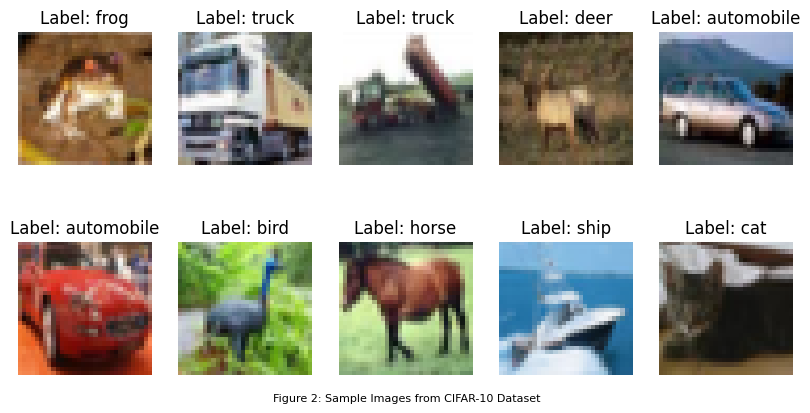

In [39]:
# combine all data
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# show the shape of the dataset and labels
print('Combined dataset shape:', X_all.shape, y_all.shape)

# create label-name dictionary
label_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
} 

# visualize some sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_all[i])
    ax.set_title(f'Label: {label_names[y_all[i][0]]}')
    ax.axis('off')
fig.text(0.38,
         0.1,
         'Figure 2: Sample Images from CIFAR-10 Dataset',
         fontsize=8)

The input to a simple neural network must be a vector, which necessitates the transformation of these image tensors to a vector. Flattening these images will produce a vector of size (3072,) that can then be used as the input features to the neural network. As discussed previously, this destroys some information but is necessary for this model.

Another step that must be made is normalizing the elements of this vector. Normalization is the process of transforming all the data such that any data fall within a certain bound or distribution. Normalization does not add information but makes learning easier and more reliable. Integer inputs can lead to unecessarily large or uneven first layer activations. It also reduces the presence of global brightness differences, meaning that training can focus on learning relevant patterns rather than absolute intensity, potentially leading to improved generalizability.

In this case, the data will be normalized per channel as it will conserve the natural structure of the color data, which the neural network may leverage.

In [51]:
from random import shuffle
# first, split data into train, validation, and test sets
# shuffle data
indices = list(range(X_all.shape[0]))
shuffle(indices) # inbuilt shuffle function
X_all = X_all[indices]
y_all = y_all[indices]

# split data
X_train = X_all[:40000]
y_train = y_all[:40000]
X_val = X_all[40000:50000]
y_val = y_all[40000:50000]
X_test = X_all[50000:]
y_test = y_all[50000:]

# one-hot encode labels
y_train_oh = to_categorical(y_train, num_classes=10)
y_val_oh = to_categorical(y_val, num_classes=10)
y_test_oh = to_categorical(y_test, num_classes=10)

##### GPU-optimized tf.data pipeline

The helper functions below keep the 4070ti busy by overlapping data preprocessing with GPU execution. Normalization runs once per batch while augmentation introduces controlled randomness, and caching/prefetching ensure the next batch is ready before the GPU needs it.

In [104]:
# moving datasets to gpu friendly tf.data pipelines
Batch_Size = 512
AUTOTUNE = tf.data.AUTOTUNE

# get normalization parameters from training data
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
mean_tf = tf.constant(mean, dtype=tf.float32)
std_tf = tf.constant(std, dtype=tf.float32)

# training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh))
train_ds = (
    train_ds
    .map(lambda x, y: ((tf.cast(x, tf.float32) - mean_tf) / std_tf, tf.cast(y, tf.float32)),
         num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=40000)
    .batch(Batch_Size, drop_remainder=False)
    .prefetch(buffer_size=AUTOTUNE)
)

# validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_oh))
val_ds = (
    val_ds
    .map(lambda x, y: ((tf.cast(x, tf.float32) - mean_tf) / std_tf, tf.cast(y, tf.float32)),
         num_parallel_calls=AUTOTUNE)
    .batch(Batch_Size, drop_remainder=False)
    .prefetch(buffer_size=AUTOTUNE)
)

# test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_oh))
test_ds = (
    test_ds
    .map(lambda x, y: ((tf.cast(x, tf.float32) - mean_tf) / std_tf, tf.cast(y, tf.float32)),
         num_parallel_calls=AUTOTUNE)
    .batch(Batch_Size, drop_remainder=False)
    .prefetch(buffer_size=AUTOTUNE)
)

Normalization as a step can actually be handled natively by kears using a normalization layer: `layers.Normalization()` which takes an axis perameter on which to normalize.

The flatten step can be baked into the model in a similar maner using `layer.Flatten()` and will change any input tensor to shape `(n,)`.

The label set must also be encoded into one-hot encoding. Our model will have 10 outputs and thus expects training data labels of shape (10,). The function `to_categorical` from `keras.utils` can be used to perform this transformation.

##### Post-Processing & Varification

We can now verify that the pre-processing steps have been correctly applied by checking the shapes of the datasets and visualizing some samples to ensure they appear as expected. Additionally, we can check the mean and standard deviation of the normalized data to confirm that normalization has been performed correctly.

In [105]:
# check normalization by checking mean and std of training data
# accumulate statistics over a few batches
x, y = next(iter(train_ds))

x_np = x.numpy()
y_np = y.numpy()

# calcualte mean of each channel
print(np.mean(x_np, axis=(0, 1, 2)))
# calculate std of each channel
print(np.std(x_np, axis=(0, 1, 2)))

[0.02331872 0.0450698  0.05695611]
[0.9939639 1.0009652 1.0081092]


Text(0.38, 0.1, 'Figure 3: Sample Images from Normalized Training Set')

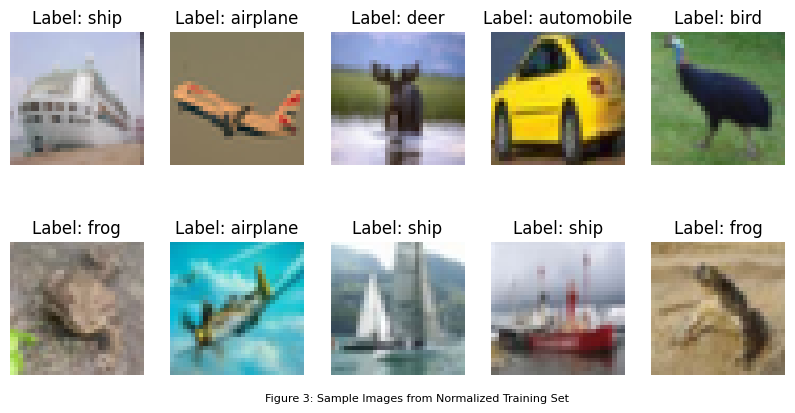

In [106]:
# sample visualization after preprocessing
x, y = next(iter(train_ds))
images = x[0:10].numpy()

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # denormalize for visualization
    ax.imshow((images[i] * std_tf + mean_tf).numpy().astype(np.uint8))
    ax.set_title(f'Label: {label_names[np.argmax(y.numpy()[i])]}')
    ax.axis('off')

fig.text(0.38,
         0.1,
         'Figure 3: Sample Images from Normalized Training Set',
         fontsize=8)

These verifications help ensure that the preprocessing steps have been implemented correctly and that the data is in the expected format for model training.

### 5 | Developing and Comparing Two Small Models
---
This section will cover the creation of two small models for CIFAR-10 classification, their training, evaluation, and comparison. We expect these small models to outperform the naive baseline while being lightweight enough to train quickly and have very little risk of overfitting.

Both models will use the RMSprop optimizer with a learning rate of 0.001, categorical cross-entropy loss, and will be trained for 10 epochs with a batch size of 64. Batched training helps stabilize gradient estimates and can improve convergence speed.

Both models will utilize the rectified linear unit (ReLU) activation function in their hidden layers. ReLU is computationally efficient and helps mitigate the vanishing gradient problem, facilitating deeper networks to learn effectively, although in these small models depth is limited.

Both models will also use an output layer of size 10 with softmax activation. Softmax converts raw output scores into probabilities that sum to one, making it suitable for multi-class classification tasks like CIFAR-10.

Both models will use categorical cross-entropy as the loss function. This loss function quantifies the dissimilarity between the predicted probability distribution and the true distribution (one-hot encoded labels), guiding the optimization process to improve classification accuracy.

The keras API will be used to define, compile, and train the models. The `Sequential` model class allows for easy stacking of layers in a linear fashion. The keras API is a high-level interface for tensorflow that simplifies model building and training.

##### Model 1 (two hidden 16-unit layers)

This model consists of two hidden layers, each with 16 units and ReLU activations, followed by an output layer with 10 units and softmax activation. The architecture is as follows:

In [109]:
# set random seed for reproducibility
keras.utils.set_random_seed(128)


# define model architecture
model_1 = Sequential()
model_1.add(Input(shape=(32, 32, 3)))  # CIFAR-10 image shape
model_1.add(Flatten())  # flatten 2D images to 1D vectors
model_1.add(Dense(16, activation='relu'))  # first hidden layer with
model_1.add(Dense(16, activation='relu'))  # second hidden layer with
model_1.add(Dense(10, activation='softmax'))  # output layer for 10 classes

# compile model
model_1.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), # using RMSprop optimizer
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), # categorical crossentropy loss
                metrics=['accuracy',
                         keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_accuracy'),],
                run_eagerly=False
                )

# show model summary
model_1.summary()

# train model
history = model_1.fit(train_ds, # training data
                      epochs=30, # number of epochs
                      validation_data=val_ds # validation data
                      )



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_14 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │        49,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,610 (193.79 KB)

 Trainable params: 49,610 (193.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2815 - loss: 2.0304 - top_2_accuracy: 0.4630 - val_accuracy: 0.3067 - val_loss: 1.9410 - val_top_2_accuracy: 0.5032
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3674 - loss: 1.8023 - top_2_accuracy: 0.5619 - val_accuracy: 0.3537 - val_loss: 1.8615 - val_top_2_accuracy: 0.5517
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3895 - loss: 1.7318 - top_2_accuracy: 0.5897 - val_accuracy: 0.3716 - val_loss: 1.8001 - val_top_2_accuracy: 0.5719
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4041 - loss: 1.6877 - top_2_accuracy: 0.6043 - val_accuracy: 0.3871 - val_loss: 1.7778 - val_top_2_accuracy: 0.5847
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4164 - loss: 1.6551 - top_2_accuracy: 0.6148 - val_accuracy: 0.3663 - val_loss: 1.8266 - val_top_2_accuracy: 0.5568
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4234 - loss: 1.6324 - top_2_acc

The number of epochs was chosen to be 20, but early stopping could be implemented to halt training if validation performance ceases to improve, preventing overfitting. To check if early stopping would help, the history object that is returned from the `model.fit()` function can be inspected to see if validation accuracy plateaus or decreases before the maximum number of epochs is reached. 

If early stopping is beneficial, it can either be implemented manually by chosing the epoch with the best validation accuracy from the history object and restoring model weights to that epoch, or by using the `EarlyStopping` callback in keras, which automates this process.

Below is an inspection of the training history to determine if early stopping would be beneficial.

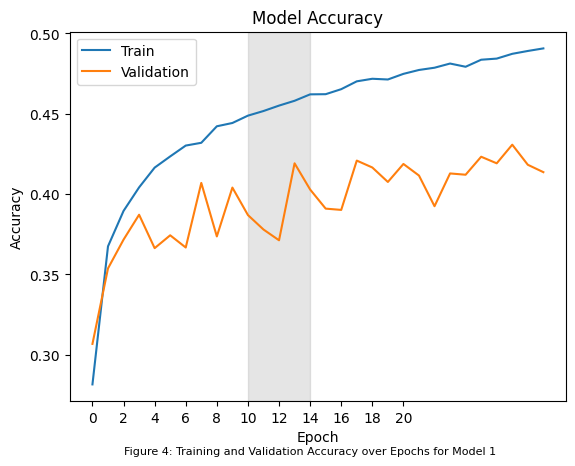

In [110]:
# plot training & validation accuracy values
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_xticks(range(0, 21, 2))
ax.legend(['Train', 'Validation'], loc='upper left')

# figure text
fig.text(0.5,
         0,
         'Figure 4: Training and Validation Accuracy over Epochs for Model 1',
         ha='center',
         fontsize=8)

# shade area indicating potential early stopping point
ax.axvspan(10, 14, color='grey', alpha=0.2)
plt.show()

Figure 4 shows the training and validation accuracy over epochs for Model 1. If the validation accuracy plateaus or decreases while training accuracy continues to increase, it indicates overfitting, suggesting that early stopping could be beneficial. The grey line indicates the epoch with the highest validation accuracy, which could be used as a stopping point. The mode can be re-trained using this epoch as the stopping point to potentially improve generalization.

In [95]:
keras.utils.set_random_seed(128)
# re-train model for 10 epochs
model_1.fit(train_ds,
            epochs=12,
            validation_data=val_ds
            )

Epoch 1/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3839 - loss: 1.9485 - top_2_accuracy: 0.5674 - val_accuracy: 0.4068 - val_loss: 1.7096 - val_top_2_accuracy: 0.6072
Epoch 2/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4641 - loss: 1.5279 - top_2_accuracy: 0.6662 - val_accuracy: 0.4397 - val_loss: 1.6135 - val_top_2_accuracy: 0.6332
Epoch 3/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4786 - loss: 1.4815 - top_2_accuracy: 0.6796 - val_accuracy: 0.4426 - val_loss: 1.6008 - val_top_2_accuracy: 0.6429
Epoch 4/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4825 - loss: 1.4670 - top_2_accuracy: 0.6831 - val_accuracy: 0.4353 - val_loss: 1.6118 - val_top_2_accuracy: 0.6322
Epoch 5/12
78/78 ━━━━━━━━━━━━━━━━━━━━ -1s 10ms/step - accuracy: 0.4875 - loss: 1.4554 - top_2_accuracy: 0.6884 - val_accuracy: 0.4417 - val_loss: 1.5979 - val_top_2_accuracy: 0.6408
Epoch 6/12
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4865 - loss: 1.4549 - top_2_ac

In [103]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# repoducibility
keras.utils.set_random_seed(128)

# evaluate model on test set
test_loss, test_acc, test_top_2_acc = model_1.evaluate(test_ds, verbose=2)
# confusion matrix
y_pred = model_1.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_oh, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# plot confusion matrix as heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=ax)
plt.title('Confusion Matrix for Model 1 on CIFAR-10 Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.text(5,
         11.5,
         'Figure 5: Confusion Matrix for Model 1 on CIFAR-10 Test Set',
         ha='center',)

# print test accuracy
print('\nTest accuracy:', test_acc)
print('Test top-2 accuracy:', test_top_2_acc)

19/19 - 0s - 12ms/step - accuracy: 0.4263 - loss: 1.6406 - top_2_accuracy: 0.6359
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


ValueError: Found input variables with inconsistent numbers of samples: [10000, 9728, 10000]


##### Model 2 (one hidden 32-unit layer)

This model consists of a single hidden layer with 32 units and ReLU activation, followed by an output layer with 10 units and softmax activation. The architecture is as follows:

In [17]:
# set random seed for reproducibility
keras.utils.set_random_seed(128)

# define model architecture
model_2 = Sequential()
model_2.add(Input(shape=(32, 32, 3)))  # CIFAR-10 image shape
model_2.add(Flatten())  # flatten 2D images to 1D vectors
model_2.add(Dense(32, activation='relu'))  # first hidden layer with 32 units
model_2.add(Dense(10, activation='softmax'))  # output layer for 10 classes

# compile model
model_2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), # using RMSprop optimizer
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), # categorical crossentropy loss
                metrics=['accuracy',
                         keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_accuracy'),]
                )

# show model summary
model_2.summary()

# train model
history_2 = model_2.fit(X_train, # training data
                        y_train_oh, # training labels
                        epochs=20, # number of epochs
                        batch_size=64, # batch size
                        validation_data=(X_val, y_val_oh) # validation data
                        )

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        98,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,666 (385.41 KB)

 Trainable params: 98,666 (385.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/home/administrator/wsl-tf/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:1172: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3499 - loss: 1.9776 - top_2_accuracy: 0.5436 - val_accuracy: 0.3941 - val_loss: 1.8203 - val_top_2_accuracy: 0.5821
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4190 - loss: 1.6822 - top_2_accuracy: 0.6220 - val_accuracy: 0.4205 - val_loss: 1.7021 - val_top_2_accuracy: 0.6159
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4532 - loss: 1.5664 - top_2_accuracy: 0.6571 - val_accuracy: 0.4363 - val_loss: 1.6309 - val_top_2_accuracy: 0.6364
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4763 - loss: 1.4990 - top_2_accuracy: 0.6772 - val_accuracy: 0.4428 - val_loss: 1.6098 - val_top_2_accuracy: 0.6413
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4893 - loss: 1.4549 - top_2_accuracy: 0.6907 - val_accuracy: 0.4442 - val_loss: 1.5987 - val_top_2_accuracy: 0.6448
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5016 - loss: 1.4219 - top_2_accurac

We can again inspect the training history to determine if early stopping would be beneficial for this model.

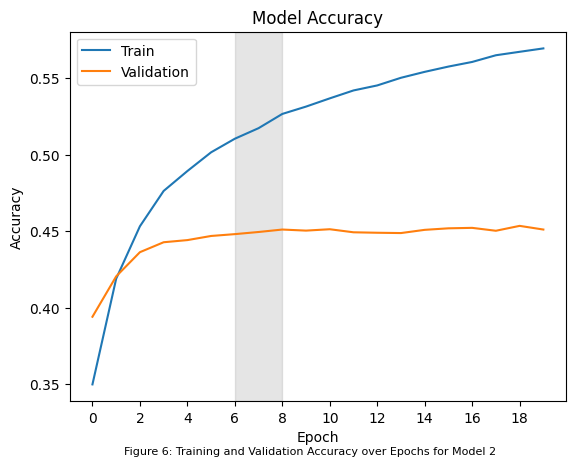

In [18]:
# plot training & validation accuracy values
fig, ax = plt.subplots()
ax.plot(history_2.history['accuracy'])
ax.plot(history_2.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_xticks(range(0, 21, 2))
ax.legend(['Train', 'Validation'], loc='upper left')
# figure text
fig.text(0.5,
         0,
         'Figure 6: Training and Validation Accuracy over Epochs for Model 2',
         ha='center',
         fontsize=8)

# shade area indicating potential early stopping point
ax.axvspan(6, 8, color='grey', alpha=0.2)
plt.show()

Omn this dataset, early stopping appears to be beneficial again, with validation accuracy peaking around epoch 6-8 in figure 6. The model can be re-trained using this epoch as the stopping point to potentially improve generalization.

In [19]:
keras.utils.set_random_seed(128)
# re-train model for 7 epochs
model_1.fit(X_train,
            y_train_oh,
            epochs=7,
            batch_size=64,
            validation_data=(X_val, y_val_oh)
            )

Epoch 1/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5162 - loss: 1.3466 - top_2_accuracy: 0.7175 - val_accuracy: 0.4366 - val_loss: 1.6509 - val_top_2_accuracy: 0.6303
Epoch 2/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5195 - loss: 1.3437 - top_2_accuracy: 0.7196 - val_accuracy: 0.4386 - val_loss: 1.6591 - val_top_2_accuracy: 0.6292
Epoch 3/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5198 - loss: 1.3409 - top_2_accuracy: 0.7189 - val_accuracy: 0.4373 - val_loss: 1.6628 - val_top_2_accuracy: 0.6319
Epoch 4/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5216 - loss: 1.3371 - top_2_accuracy: 0.7210 - val_accuracy: 0.4350 - val_loss: 1.6602 - val_top_2_accuracy: 0.6319
Epoch 5/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5225 - loss: 1.3343 - top_2_accuracy: 0.7216 - val_accuracy: 0.4351 - val_loss: 1.6683 - val_top_2_accuracy: 0.6293
Epoch 6/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5236 - loss: 1.3316 - top_2_ac

313/313 - 0s - 1ms/step - accuracy: 0.4563 - loss: 1.6716 - top_2_accuracy: 0.6567
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step

Test accuracy: 0.4562999904155731
Test top-2 accuracy: 0.6567000150680542


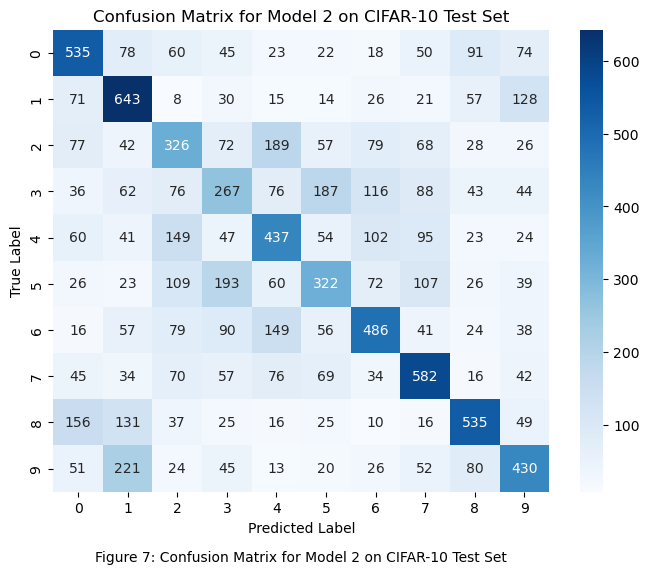

In [62]:
# repoducibility
keras.utils.set_random_seed(128)

# evaluate model on test set
test_loss, test_acc, test_top_2_acc = model_2.evaluate(X_test, y_test_oh, verbose=2)
# confusion matrix
y_pred = model_2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_oh, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# plot confusion matrix as heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=ax)
plt.title('Confusion Matrix for Model 2 on CIFAR-10 Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.text(5,
         11.5,
         'Figure 7: Confusion Matrix for Model 2 on CIFAR-10 Test Set',
         ha='center',)

# print test accuracy
print('\nTest accuracy:', test_acc)
print('Test top-2 accuracy:', test_top_2_acc)

##### Comparison & Discussion

Model 1 achieved a test accuracy of ~41% and a top-2 accuracy of ~61%, while Model 2 achieved a test accuracy of ~46% and a top-2 accuracy of ~66%.

Model 2 outperforms Model 1 in both primary and additional metrics, suggesting that a single larger hidden layer is more effective than two smaller layers for this task. This is likely due to a 16 unit layer causing a loss of discriminative directions in representational space to capture all the information present in the 3072 input dimensions, whereas a 32 unit layer provides greater capacity to learn relevant patterns.

Model 2 also achieves peak validation performance in fewer epochs, indicating more efficient learning. In Model 1, both hidden layers must be learned simultaneously, and the first layer is trained indirectly through a second layer whose parameters are still evolving. This creates a moving target problem, resulting in noisier gradient signals to the early layers and slower stabilisation of useful representations. By contrast, the single hidden layer in Model 2 is optimised directly against the loss, facilitating faster convergence.

Narrow bottlenecks such as in model 1 can also increase gradient variance. Each unit carries a large fraction of the representational burden, so small weight updates can lead to large changes in output, destabilizing learning. A wider layer as in model 2 distributes this burden across more units, smoothing gradients and improving training stability.

In summary, Model 2's capacity-focused architecture enables it to learn more effectively from the CIFAR-10 data, leading to superior classification performance compared to Model 1, which fails to transmit sufficient information through its narrow hidden layers.



### 6 | Scaling up: Overfitting Experiment
---

It was observed that an increase in model capacity from Model 1 to Model 2 led to improved performance, suggesting that further scaling up could yield additional gains. However, larger models are more prone to overfitting, where they memorize training data rather than learning generalizable patterns. To investigate this, a larger model (Model 3) with increased depth and width will be developed and evaluated.

##### Model 3 (256-128-64)

This model consists of three hidden layers with decreasing units (256, 128, 64) and ReLU activations, followed by an output layer with 10 units and softmax activation. It will be compiled with the same optimizer and loss function as the two smaller previous models. The architecture is as follows:

In [99]:
# repoducibility
keras.utils.set_random_seed(128)

# model 3 architecture
model_3 = Sequential()
model_3.add(Input(shape=(32, 32, 3)))  # CIFAR-10 image shape
model_3.add(Flatten())  # flatten 2D images to 1D vectors
model_3.add(Dense(256, activation='relu'))  # second hidden layer with 256 units
model_3.add(Dense(128, activation='relu'))  # third hidden layer with 128 units
model_3.add(Dense(64, activation='relu'))   # fourth hidden layer with 64 units
model_3.add(Dense(10, activation='softmax'))  # output layer for 10 classes

# compile model
model_3.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), # using RMSprop optimizer
                loss=keras.losses.CategoricalCrossentropy(from_logits=True), # categorical crossentropy loss
                metrics=['accuracy',
                         keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_accuracy'),],
                run_eagerly=False
                )

model_3.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 828,490 (3.16 MB)

 Trainable params: 828,490 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# fit model
history_3 = model_3.fit(train_ds, # training data
                        epochs=30, # number of epochs
                        validation_data=val_ds # validation data
                        )

Epoch 1/30


/home/administrator/wsl-tf/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:1172: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-12-19 17:32:18.104531: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-19 17:32:18.104626: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-19 17:32:19.463352: I external

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.3372 - loss: 1.9557 - top_2_accuracy: 0.5263 - val_accuracy: 0.3760 - val_loss: 1.7756 - val_top_2_accuracy: 0.5819
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4282 - loss: 1.6241 - top_2_accuracy: 0.6310 - val_accuracy: 0.4365 - val_loss: 1.6310 - val_top_2_accuracy: 0.6307
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4782 - loss: 1.4946 - top_2_accuracy: 0.6752 - val_accuracy: 0.4487 - val_loss: 1.5669 - val_top_2_accuracy: 0.6505
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5099 - loss: 1.4018 - top_2_accuracy: 0.7092 - val_accuracy: 0.4733 - val_loss: 1.5220 - val_top_2_accuracy: 0.6733
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5347 - loss: 1.3283 - top_2_accuracy: 0.7297 - val_accuracy: 0.4813 - val_loss: 1.4824 - val_top_2_accuracy: 0.6889
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5603 - loss: 1.2620 - top_2_accuracy: 0.7512 

Model 3 has ~800,000 parameters, significantly more than Models 1 and 2 at ~50,000 and ~100,000 parameters respectively. This substantial increase in capacity allows the model to learn complex patterns but also significantly raises the computational cost of each training epoch and increases the risk of overfitting.

Like for the previous models, the training history can be inspected to determine if the model is overfitting during training.

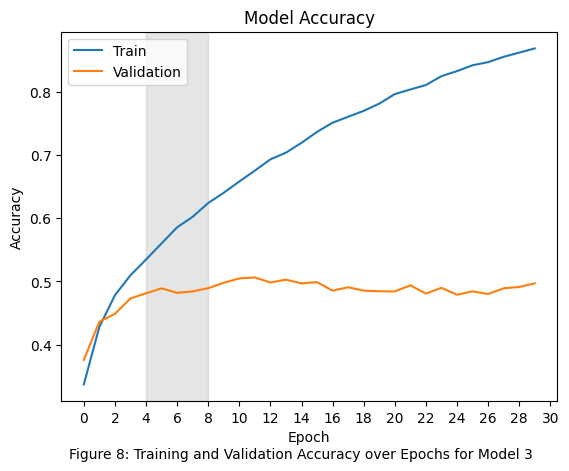

19/19 - 0s - 11ms/step - accuracy: 0.4963 - loss: 2.3613 - top_2_accuracy: 0.6870

Test accuracy: 0.4962993562221527
Test top-2 accuracy: 0.6869860291481018


In [102]:
# plot training & validation accuracy values
fig, ax = plt.subplots()
ax.plot(history_3.history['accuracy'])
ax.plot(history_3.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_xticks(range(0, 31, 2))
ax.legend(['Train', 'Validation'], loc='upper left')
# figure text
fig.text(0.5,
         0,
         'Figure 8: Training and Validation Accuracy over Epochs for Model 3',
         ha='center',
         va='center')

# shade area indicating potential early stopping point
ax.axvspan(4, 8, color='grey', alpha=0.2)
plt.show()

# scores on test set
test_loss, test_acc, test_top_2_acc = model_3.evaluate(test_ds, verbose=2)
print('\nTest accuracy:', test_acc)
print('Test top-2 accuracy:', test_top_2_acc)

##### Results & Discussion

Figure 8 shows the training and validation accuracy over epochs for Model 3. The validation accuracy peaks around epoch 4-6, after which it plateaus and gently declines while training accuracy continues to rise, indicating overfitting.

We can see that even to epoch 30, the model continues to increse training accuracy while validation accuracy declines, a classic sign of overfitting.

Overfitting is where a model stops learning generalizable patterns and instead memorizes the training data. Overfitting typically occurs when a model has excessive capacity relative to the amount of training data, allowing it to fit noise and idiosyncrasies in the training set that do not generalize to unseen data. In this case, Model 3's large number of parameters enables it to memorize training samples very effectively, leading to high training accuracy but poor validation performance.

The scores and metrics for model 3 on the test set also reflect this overfitting, with a test accuracy of ~46% and a top-2 accuracy of ~65%, which are extremely similar to model 2's performance despite the vastly increased capacity. This indicates that the additional parameters did not translate into better generalization, as the model likely memorized training data rather than learning useful features.

### 7 | Regularizing and Hyperparameter Tuning
---

Regularization and hyperparameter tuning are essential techniques to improve model generalization and performance. Regularization methods help prevent overfitting by constraining the model's capacity, while hyperparameter tuning optimizes the model's architecture and training process.

##### Experiments Setup

The regularization techniques to be explored include L1 and L2 regularization and dropout. L1 regularization adds a penalty proportional to the absolute values of the weights, promoting sparsity. L2 regularization adds a penalty proportional to the squared values of the weights, discouraging large weights. Dropout randomly deactivates a fraction of neurons during training, preventing co-adaptation and encouraging robust feature learning.

The hyperparameters to be tuned include which optimizer to use (RMSprop, Adam, SGD), learning rate (0.1, 0.01, 0.001), batch size (32, 64, 128), number of hidden layers (2, 3, 4), and number of units per layer (64, 128, 256). To evaluate the impact of these choices, a grid search with 3 fold cross-validation will be conducted on the training set. Each combination of hyperparameters will be trained and validated. The results will be collected using pandas and analyzed to identify the best performing configuration.

In [82]:
# required imports
import pandas as pd

from keras.layers import Dropout
from keras.regularizers import l1, l2
from keras.optimizers import RMSprop, Adam, SGD

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# helper functions for these experiments
def build_model(
        n_hidden_layers = 2,
        units = 64,
        regularization = None,
        reg_strength = 0.001,
        dropout_rate = 0.0,
        optimizer = 'RMSprop',
        learning_rate = 0.001
):
    
    model = Sequential()

    # regularizer
    if regularization == 'l1':
        reg = l1(reg_strength)
    elif regularization == 'l2':
        reg = l2(reg_strength)
    else:
        reg = None
    
    # input layer
    model.add(Input(shape=(32, 32, 3)))  # CIFAR-10 image shape
    model.add(Flatten())  # flatten 2D images to 1D vectors

    # hidden layers
    for _ in range(n_hidden_layers):
        model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    
    # output layer
    model.add(Dense(10, activation='softmax'))  # output layer for 10 classes

    # optimizer
    if optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Choose from 'RMSprop', 'Adam', or 'SGD'.")
    
    # compile model
    model.compile(optimizer=optimizer,
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy',
                           keras.metrics.TopKCategoricalAccuracy(k=2,name='top_2_accuracy'),]
                  )
    
    return model

# wrap model for use in scikit-learn
clf = KerasClassifier(model=build_model,
                      epochs=20,
                      verbose=0)

In [87]:
# hyper-parameter grid
param_grid = {
    "model__optimizer": ["rmsprop", "adam"],
    "batch_size": [32, 64, 128],
    "model__n_hidden_layers": [1, 2],
    "model__units": [64, 128, 256],
    "model__regularization": [None, "l1", "l2"],
    "model__dropout_rate": [0.0, 0.3, 0.5],
}

# grid search with 3-fold cross-validation
grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    refit=True
)

grid_result = grid.fit(X_train, y_train)

KeyboardInterrupt: 

### Reflections

- incredibly unstable validation scores over history encountered
- the plight of GPU acceleration